# **`Face Mask Detection` with `VGG16`** 

#### **`Introduction` - Face Mask Detection**

> `Face Mask Detection` is a system that uses `Computer Vision` and Deep Learning to determine whether a person is wearing a `mask` or not. 

* It’s similar to an `Object Detection` system where a `specific class` of objects is detected.

* This system can be particularly useful in public places to ensure people’s safety during situations like the `COVID-19` pandemic. 

![Image](https://www.intertecsystems.com/wp-content/uploads/2020/05/face-mask-detection-software-e1591538656411.png)


***
***

### **1. Packages and Dataset**

* First and foremost, we import some basic `libraries`.

In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import os 

import tensorflow as tf 
from tensorflow import keras 

* In this project, we will use [Face Mask Dataset](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset) from kaggle.

* Simply `download` the dataset from the link and set directories for `Train`, `Validation` and `Test` folders.

In [ ]:
train_dir="D:\Data_Bag\AI_Repository\Face_Mask_Dataset\Train"
validation_dir="D:\Data_Bag\AI_Repository\Face_Mask_Dataset\Validation"
test_dir="D:\Data_Bag\AI_Repository\Face_Mask_Dataset\Test"

'''

### **2. Image Preprocessing**

* We will now pre-process the images using `ImageDataGenerator` from tensorflow/ keras.

* We will perform `data augmentation` and `preprocessing` on image data.

1. **train_datagen**

* `train_datagen` is an instance of `ImageDataGenerator` for `training` data. 
* It `rescales` the images by 1/255 (to convert pixel values from [0,255] to [0,1]), and applies random `transformations` (rotation, width and height shifts, shear transformation, zoom, and horizontal flip) for data augmentation. 

2. **validation_datagen**

* `validation_datagen` is another instance of `ImageDataGenerator` for `validation` data. 
* It only `rescales` the images, as we don’t want to augment our validation data.

3. **train_generator** and **validation_generator**

* `train_generator` and `validation_generator` are python generators that yield `batches` of images and labels from the directories specified (train_dir and validation_dir). 
* They `resize` the images to 150x150, and yield them in `batches` of 32. 
* The class_mode is set to `binary`, indicating that it’s a binary classification problem. 
* These generators can be directly used in the fit method of a keras model for training.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
) 
validation_datagen=ImageDataGenerator(rescale=1./255) 


train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode="binary"
    )
validation_generator=validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode="binary"
    )

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


'''

### **3. Image Classification Model** 

* Next, we will build our `Image Classification Model` using `Transfer Learning` with `VGG16`.

In [4]:
from tensorflow.keras import layers 
from tensorflow.keras import models 
from tensorflow.keras.applications.vgg16 import VGG16 

* This code is setting up Transfer Learning with the `VGG16` model. 

* It uses VGG16’s `pre-trained weights` from `ImageNet`, excludes its `top` layers, and `freezes` the remaining layers to keep their weights fixed during training.

In [5]:
vgg_base=VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))
for layer in vgg_base.layers:
    layer.trainable=False

In the code below, we build a **Sequential** model in Keras.

* It starts by adding the pre-trained `VGG16 base` model.

* Then, it adds several `Convolutional` and `MaxPooling` layers for `feature extraction` from images.

* The `Flatten` layer is used to convert the `2D` feature maps to `1D` feature vectors.

* The `Dropout` layer randomly sets `50`% of the `input` units to `0` at each update during training, which helps `prevent overfitting`.

* The `Dense` layers are fully connected layers. The final `Dense` layer uses a `sigmoid` activation function, making the model suitable for `binary classification`.


In [6]:
model=models.Sequential() 

model.add(vgg_base)
model.add(layers.MaxPooling2D((2,2))) 
model.add(layers.Conv2D(128, (3,3), activation="relu", padding="same")) 
model.add(layers.MaxPooling2D((2,2), padding="same")) 
model.add(layers.Conv2D(128, (3,3), activation="relu", padding="same")) 
model.add(layers.MaxPooling2D((2,2), padding="same")) 

model.add(layers.Flatten()) 
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(512, activation="relu")) 
model.add(layers.Dense(1, activation="sigmoid")) 

In [7]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 128)         589952    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

'''

### **4. Callbacks**

* Now, we will set a `callback` to `save` the `best` model.

* We first create a `directory` to save the model if it doesn’t exist.

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a directory to save the best model
checkpoint_dir="./"
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

* We then specify the `path` where the `best model` will be saved (`best_model.h5`).

* The `ModelCheckpoint` callback saves the model at `every epoch`. It monitors the `validation` loss (val_loss), and only the model with the `minimum` validation loss is saved (mode="min", save_best_only=True).

* It `saves` the `entire model`, not just the weights (save_weights_only=False).

* It prints a message every time the model is saved (verbose=1).

In [9]:
checkpoint_filepath=os.path.join(checkpoint_dir, "best_model.h5")
model_checkpoint_callback=ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

'''

### **5. Training the Model**

* Finally, we train our model.

* We start by compiling our model with `binary_crossentropy` as loss function, use `RMSprop` as the optimizer and use `accuracy` as the metrics for evaluation.

In [10]:
from tensorflow.keras import optimizers 

model.compile(loss="binary_crossentropy",
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=["acc"]) 

* Now we train the model for `30` epochs with `train_generator` as training data and `validation_generator` as validation data. 

* We also use the `model_checkpoint_callback` to save the best model. 

* We performs `100` steps per epoch for `training` and `10` steps for `validation`.

In [11]:
history=model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/30
100/100 [==============================] - 15s 112ms/step - loss: 0.6791 - acc: 0.6247 - val_loss: 0.6377 - val_acc: 0.9125

Epoch 00001: val_loss improved from inf to 0.63765, saving model to ./Live_Face_Detection\best_model.h5
Epoch 2/30
100/100 [==============================] - 11s 110ms/step - loss: 0.6158 - acc: 0.8300 - val_loss: 0.5220 - val_acc: 0.9094

Epoch 00002: val_loss improved from 0.63765 to 0.52196, saving model to ./Live_Face_Detection\best_model.h5
Epoch 3/30
100/100 [==============================] - 11s 109ms/step - loss: 0.5180 - acc: 0.8813 - val_loss: 0.3817 - val_acc: 0.9312

Epoch 00003: val_loss improved from 0.52196 to 0.38172, saving model to ./Live_Face_Detection\best_model.h5
Epoch 4/30
100/100 [==============================] - 11s 109ms/step - loss: 0.4000 - acc: 0.9094 - val_loss: 0.2871 - val_acc: 0.9187

Epoch 00004: val_loss improved from 0.38172 to 0.28706, saving model to ./Live_Face_Detection\best_model.h5
Epoch 5/30
100/100 [========

'''

### **6. Plotting Loss and Accuracy Graphs**

* Now, we use `matplotlib.pyplot` to plot two graphs: 

    * `Training Loss` and `Validation Loss`
    * `Training Accuracy` and `Validation Accuracy`

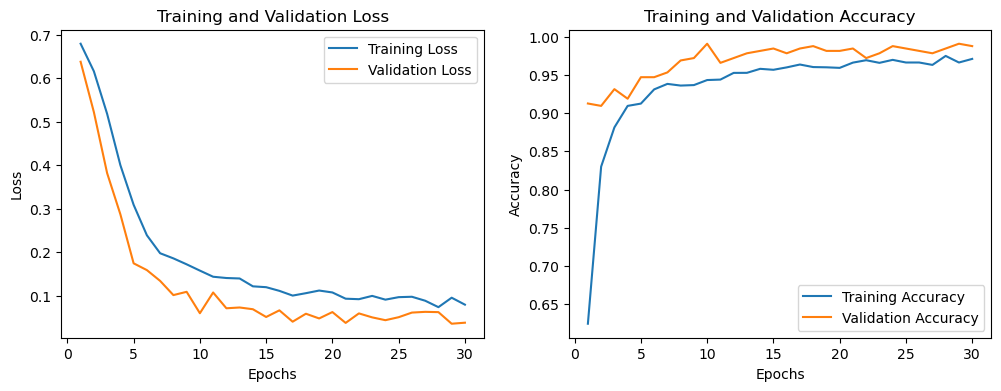

In [12]:
# Retrieve loss and accuracy values from the training history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, len(train_loss) +1)

# Plot and label the training and validation loss values
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")

# Plot and label the training and validation accuracy values
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")

# Display the plots
plt.show()

'''

### **7. Testing Model**

* Let's `benchmark` our model.

* First, we `clear` the `session` and `delete` the model from `memory`.

In [11]:
from tensorflow.keras import backend as k

k.clear_session()
del model 

* Now, we `load` our `Best Model`.

In [12]:
model=tf.keras.models.load_model(checkpoint_filepath)

* We pre-`process` `Test` images using `ImageDataGenerator`.

In [13]:
test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode="binary"
)

Found 981 images belonging to 2 classes.


* Now, we `evaluate` our model.

* Our model shows `accuracy` of `98.8 percent` on `unseen data`. This is a very good performance.

In [14]:
model.evaluate(test_generator, steps=50) 

50/50 [==============================] - 4s 21ms/step - loss: 0.0290 - acc: 0.9888


[0.02898399718105793, 0.9887869358062744]

***
***